In [1]:
using DataFrames
using DifferentialEquations
using Plots

In [2]:
Base.@kwdef struct Parameters
    Cₘ::Float64  = 1.0
    gI::Float64  = 4.0    # nS
    gK::Float64  = 0.3    # nS
    gₕ::Float64  = 0.03   # nS
    gL::Float64  = 0.003  # nS
    gT::Float64  = 0.01   # nS
    gKCa::Float64 = 0.03  # nS
    EI::Float64  = 30.0   # mV
    EK::Float64  = -75.0  # mV
    Eₕ::Float64  = 70.0   # mV
    EL::Float64  = -40.0  # mV
    ECa::Float64 = 140.0  # mV
    Kc::Float64  = 0.0085 # mV⁻¹
    τₓ::Float64  = 100.0  # ms, 235ms also used
    ρ::Float64   = 0.0003 # ms⁻¹
    Δx::Float64  = 0.0    # mm
    ΔCa::Float64 = 0.0    # ms
end
θ = Parameters()

Parameters(0.001, 1.0, 4.0, 0.3, 0.03, 0.003, 0.01, 0.03, 30.0, -75.0, 70.0, -40.0, 140.0, 0.0085, 100.0, 0.0003, 0.0, 0.0)

In [3]:
Vₛ(V::Float64)::Float64 = (127.0 * V + 8265.0) / 105.0

Vₛ (generic function with 1 method)

In [4]:
function ɑₘ(V::Float64)::Float64
    Vs = Vₛ(V)
    0.1 * (50.0 - Vs)/(exp((50-Vs) / 10.0) - 1.0) # This minus was a plus in the paper. I found that it should be a minus by looking through the MATCONT melibeNew system equations.
end

βₘ(V::Float64)::Float64 = 4.0 * exp((25.0-Vₛ(V)) / 18.0)
m∞(V::Float64)::Float64 = ɑₘ(V) / (ɑₘ(V) + βₘ(V))
# Fast inward sodium and calcium current
II(θ::Parameters, h::Float64, V::Float64)::Float64 = θ.gI * h * m∞(V)^3 * (V - θ.EI)

II (generic function with 1 method)

In [5]:
ɑₕ(V::Float64)::Float64 = 0.07 * exp((25.0 - Vₛ(V)) / 20.0)
βₕ(V::Float64)::Float64 = 1.0 / (1.0 + exp((55.0 - Vₛ(V)) / 10.0))
h∞(V::Float64)::Float64 = ɑₕ(V) / (ɑₕ(V) + βₕ(V))
τₕ(V::Float64)::Float64 = 12.5 / (ɑₕ(V) + βₕ(V))
Iₕ(θ::Parameters, y::Float64, V::Float64)::Float64 = θ.gₕ * y * (V - θ.Eₕ) / (1.0 + exp((63.0 - V) / 7.8))^3
dh(h::Float64, V::Float64)::Float64 = (h∞(V) - h) / τₕ(V)

dh (generic function with 1 method)

In [6]:
function ɑₙ(V::Float64)::Float64
    Vs = Vₛ(V)
    0.01 * (55.0 - Vs) / (exp((55.0 - Vs) / 10.0) - 1.0)
end

βₙ(V::Float64)::Float64 = 0.125 * exp((45.0 - Vₛ(V)) / 80.0)
n∞(V::Float64)::Float64 = ɑₙ(V) / (ɑₙ(V) + βₙ(V))
τₙ(V::Float64)::Float64 = 12.5 / (ɑₙ(V) + βₙ(V))
IK(θ::Parameters, n::Float64, V::Float64)::Float64 = θ.gK * n^4 * (V - θ.EK)
dn(θ::Parameters, n::Float64, V::Float64)::Float64 = (n∞(V) - n) / τₙ(V)

dn (generic function with 1 method)

In [7]:
IT(θ::Parameters, x::Float64, V::Float64)::Float64 = θ.gT * x * (V - θ.EI)

IT (generic function with 1 method)

In [8]:
IT(θ::Parameters, x::Float64, V::Float64)::Float64 = θ.gT * x * (V - θ.EI)
x∞(θ::Parameters, V::Float64)::Float64 = 1.0 / (1.0 + exp(0.15 * (θ.Δx - V - 50)))
dx(θ::Parameters, x::Float64, V::Float64)::Float64 = (x∞(θ, V) - x) / θ.τₓ

dx (generic function with 1 method)

In [9]:
dy(θ::Parameters, y::Float64, V::Float64)::Float64 = (1 / (1 + exp(10 * (V - 50))) - y) / (14.2 + 20.8 / (1 + exp((V + 68.0) / 2.2)))

dy (generic function with 1 method)

In [10]:
Iₗₑₐₖ(θ::Parameters, V::Float64)::Float64 = θ.gL * (V - θ.EL)

Iₗₑₐₖ (generic function with 1 method)

In [11]:
IKCa(θ::Parameters, Ca::Float64, V::Float64)::Float64 = θ.gKCa * Ca * (V - θ.EK) / (0.5 + Ca)
dCa(θ::Parameters, Ca::Float64, x::Float64, V::Float64)::Float64 = θ.ρ * (θ.Kc * x * (θ.ECa - V + θ.ΔCa) - Ca)

dCa (generic function with 1 method)

In [12]:
function dV(θ::Parameters, x::Float64, y::Float64, n::Float64, h::Float64, Ca::Float64, V::Float64, Isyn::Float64)::Float64
    -(II(θ, h, V) + IK(θ, n, V) + IT(θ, x, V) + IKCa(θ, Ca, V) + Iₕ(θ, y, V) + Iₗₑₐₖ(θ, V) + Isyn) / θ.Cₘ
end

dV (generic function with 1 method)

In [13]:
function melibeNew!(du, u, θ, t)
    x, y, n, h, Ca, V, Isyn = u
    du[1] = dx(θ, x, V)
    du[2] = dy(θ, y, V)
    du[3] = dn(θ, n, V)
    du[4] = dh(h, V)
    du[5] = dCa(θ, Ca, x, V)
    du[6] = dV(θ, x, y, n, h, Ca, V, Isyn)
    du[7] = 0.0
end

melibeNew! (generic function with 1 method)

In [14]:
Base.@kwdef mutable struct State
    x::Float64    = 0.7
    y::Float64    = 5.472e-46
    n::Float64    = 0.137
    h::Float64    = 0.389
    Ca::Float64   = 0.8
    V::Float64    = -62.0
    Isyn::Float64 = 0.0
end
state = State()

State(0.7, 5.472e-46, 0.137, 0.389, 0.8, -62.0, 0.0)

In [27]:
u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]
tspan = (0.0, 100000.0)
prob = ODEProblem(melibeNew!, u0, tspan, θ)
sol = solve(prob);

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 4967-element Vector{Float64}:
      0.0
      0.38999450547264647
      4.289939560199111
     32.78243268505412
     83.7852332343179
    152.38878414055625
    211.55124352180115
    233.58123487307296
    244.88252954025978
    250.04383121230538
    251.69714784590568
    252.11133490379177
    252.523490305977
      ⋮
  99346.99253237215
  99373.83838079944
  99404.96695389373
  99439.23643560181
  99479.41968572221
  99525.78694604838
  99582.14991849904
  99651.29307843017
  99739.74290749751
  99851.28532736319
  99986.12747742856
 100000.0
u: 4967-element Vector{Vector{Float64}}:
 [0.43864943359347847, 0.9999999999992117, 0.0467542604244024, 0.8383191997884312, 0.43868990033580846, -49.59895690254037, 0.0]
 [0.43894748553461466, 0.9999999999992331, 0.046795635257092426, 0.8381251585330625, 0.4387213072911519, -49.58889255171713, 0.0]
 [0.441

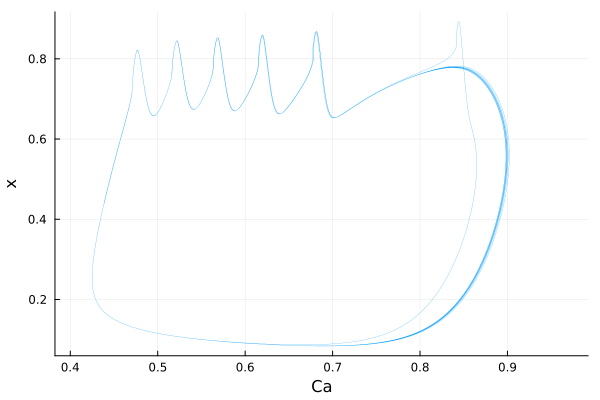

In [39]:
plot(sol, vars=(5, 1), xlabel="Ca", ylabel="x", lw=0.2, legend=false, dpi=1000)

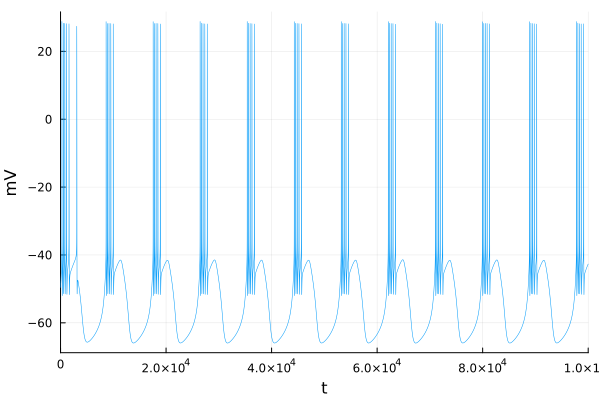

In [40]:
plot(sol, vars=(6), xlabel="t", ylabel="mV", lw=0.5, legend=false, dpi=1000)